In [1]:
import os
os.chdir('../../..')

In [2]:
import convokit

In [45]:
# CORPUS_DIR = "convokit/thread_generator/fake-corpus-trajectory"
CORPUS_DIR = "convokit/thread_generator/annotated-fake-trajectory-2"
# CORPUS_DIR = 'convokit/tensor_decomposer/experiments/reddit-trajectory-subset-annotated'
# CORPUS_DIR = "convokit/tensor_decomposer/experiments/reddit-trajectory-subset"

In [46]:
from convokit import TensorDecomposer, HyperConvo, Corpus

In [52]:
corpus = Corpus(filename=CORPUS_DIR)

In [6]:
# hyperconv_range = range(2, 20+1)

In [7]:
# hyperconv_range = range(2, 20+1)
# def multi_hyperconv_transform(corpus, hyperconv_range):
#     hc_transformers = [HyperConvo(prefix_len=i, feat_name="hyperconvo-{}".format(i)) for i in hyperconv_range]
#     for idx, hc in enumerate(list(reversed(hc_transformers))):
#         print(hyperconv_range[-1]-idx)
#         hc.transform(corpus)

In [8]:
# multi_hyperconv_transform(corpus, hyperconv_range)

In [9]:
# corpus.dump("reddit-trajectory-subset-annotated", base_path="convokit/tensor_decomposer/experiments")

In [53]:
GROUP_SIZE=333

In [88]:
import numpy as np
def _min_max_scale(mat):
    max_ = np.max(mat)
    min_ = np.min(mat)
    return (mat - min_) / (max_ - min_)

def minmax_normalize(tensor):
    tensor = tensor.copy()
    for i in range(tensor.shape[2]):
        tensor[:, :, i] = _min_max_scale(tensor[:, :, i])
    return tensor

In [55]:
hyperconv_range = range(2, 20+1)
td = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in hyperconv_range],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      rank=3
                     )

In [56]:
td.fit(corpus)

Constructing tensor...Done.
Decomposing tensor...Done.


In [14]:
# td.summarize(corpus, axis_names=["Comment idx", "Threads", "Features"], 
#              output_dir='convokit/tensor_decomposer/reports/25May_normal', 
#              report_title="25 May (normal)")

In [57]:
score = td.purity(n_clusters=3, actual_num_clusters=3, group_size=GROUP_SIZE)
print(score)

0.9569569569569569


## Standard (from 3)

In [58]:
td_3 = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in range(3, 20+1)],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      rank=3
                     )

In [59]:
td_3.fit(corpus)

Constructing tensor...Done.
Decomposing tensor...Done.


In [60]:
td_3.tensor.shape

(18, 999, 140)

In [61]:
score = td_3.purity(n_clusters=3, actual_num_clusters=3, group_size=GROUP_SIZE)
print(score)

0.9569569569569569


## Min-max normalized (across threads)

### From 2

In [62]:
td_min_max = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in range(2, 21)],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      normalize_func=minmax_normalize,
                      rank=3
                     )

In [63]:
td_min_max.fit(corpus)

Constructing tensor...Done.
Decomposing tensor...Done.


In [64]:
# td_min_max.summarize(corpus, axis_names=["Comment idx", "Threads", "Features"], 
#              output_dir='convokit/tensor_decomposer/reports/25May_minmax', 
#              report_title="25 May (min_max)")

In [65]:
score = td_min_max.purity(n_clusters=3, actual_num_clusters=3, group_size=GROUP_SIZE)
print(score)

0.8528528528528528


### From 3

In [66]:
td_min_max = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in range(3, 21)],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      normalize_func=minmax_normalize,
                      rank=3
                     )
td_min_max.fit(corpus)
td_min_max.purity(n_clusters=3, actual_num_clusters=3, group_size=GROUP_SIZE)

Constructing tensor...Done.
Decomposing tensor...Done.


0.8698698698698699

## Standard-scaled (across threads)

In [67]:
from sklearn.preprocessing import StandardScaler
def standard_scale(tensor):
    tensor = tensor.copy()
    for i in range(tensor.shape[2]):
        tensor[:, :, i] = StandardScaler().fit_transform(tensor[:, :, i])
    return tensor

### From 2

In [68]:
td_std_scale = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in hyperconv_range],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      normalize_func=standard_scale,
                      rank=3
                     )

In [69]:
td_std_scale.fit(corpus)

Constructing tensor...Done.
Decomposing tensor...Done.


In [70]:
# td_std_scale.summarize(corpus, axis_names=["Comment idx", "Threads", "Features"], 
#              output_dir='convokit/tensor_decomposer/reports/25May_std_scl', 
#              report_title="25 May (std scale)")

In [71]:
score = td_std_scale.purity(n_clusters=3, actual_num_clusters=3, group_size=GROUP_SIZE)
print(score)

0.7867867867867868


### From 3

In [72]:
td_std_scale = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in range(3, 21)],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      normalize_func=standard_scale,
                      rank=3
                     )
td_std_scale.fit(corpus)
td_std_scale.purity(n_clusters=3, actual_num_clusters=3, group_size=GROUP_SIZE)

Constructing tensor...Done.
Decomposing tensor...Done.


0.5125125125125125

## Min-max scaled (within thread)

In [73]:
def _min_max_within(mat):
    for i in range(mat.shape[1]):
        min_ = np.min(mat[:, i])
        max_ = np.max(mat[:, i])
        if max_ - min_ == 0:
            mat[:, i] = 0
        else:
            mat[:, i] = (mat[:, i] - min_)/ (max_ - min_)
    return mat

def minmax_within(tensor):
    tensor = tensor.copy()
    for i in range(tensor.shape[1]):
        tensor[:, i, :] = _min_max_within(tensor[:, i, :])
    return tensor

### From 2

In [74]:
td_min_max_within = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in hyperconv_range],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      normalize_func=minmax_within,
                      rank=3
                     )

In [75]:
td_min_max_within.fit(corpus)

Constructing tensor...Done.
Decomposing tensor...Done.


Directory already exists. Exiting summarize()


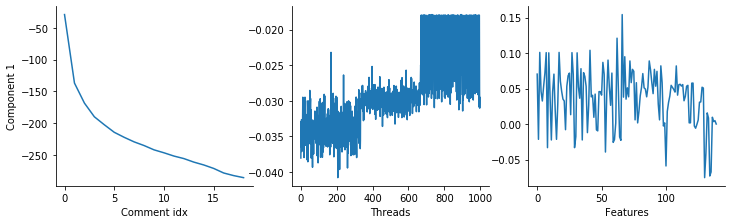

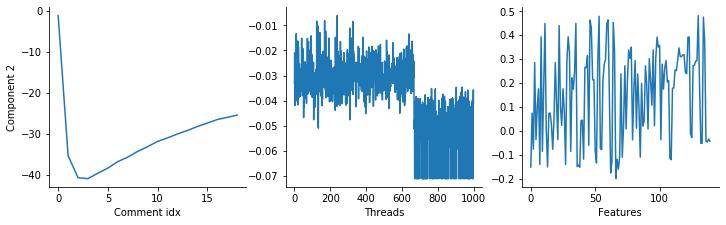

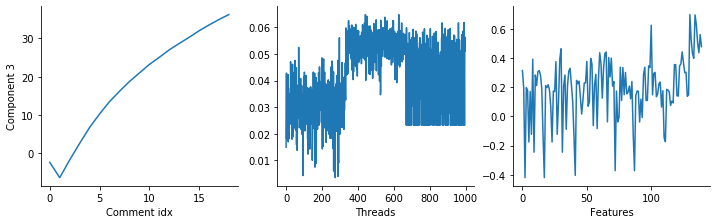

In [76]:
td_min_max_within.summarize(corpus, axis_names=["Comment idx", "Threads", "Features"], 
             output_dir='convokit/tensor_decomposer/reports/25May_minmax_within', 
             report_title="25 May (min max within)")

In [78]:
score = td_min_max_within.purity(n_clusters=3, actual_num_clusters=3, group_size=GROUP_SIZE)
print(score)

0.7897897897897898


### From 3

In [79]:
td_min_max_within = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in range(3, 21)],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      normalize_func=minmax_within,
                      rank=3
                     )

In [80]:
td_min_max_within.fit(corpus)
td_min_max_within.purity(n_clusters=3, actual_num_clusters=3, group_size=GROUP_SIZE)

Constructing tensor...Done.
Decomposing tensor...Done.


0.6136136136136137

## Standard scaling by comment index

In [81]:
from sklearn.preprocessing import scale

In [82]:
td.tensor[18, :, :]

array([[15.        ,  0.        ,  0.78947368, ...,  1.        ,
         0.        ,  0.        ],
       [15.        ,  0.        ,  0.78947368, ...,  1.        ,
         1.        ,  1.        ],
       [13.        ,  0.        ,  0.68421053, ...,  2.        ,
         1.        ,  1.        ],
       ...,
       [ 2.        ,  3.        ,  0.10526316, ...,  5.        ,
         1.        ,  7.        ],
       [ 2.        ,  1.        ,  0.10526316, ...,  6.        ,
         1.        ,  8.        ],
       [ 2.        ,  1.        ,  0.10526316, ...,  3.        ,
         1.        ,  7.        ]])

In [83]:
def scale_by_comment_idx(tensor):
    tensor = tensor.copy()
    for i in range(tensor.shape[0]):
        tensor[0, :, :] = scale(tensor[0, :, :])
    return tensor

### From 2

In [84]:
td_idx_scale = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in range(2, 21)],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      normalize_func=scale_by_comment_idx,
                      rank=3
                     )

In [85]:
td_idx_scale.fit(corpus)
td_idx_scale.purity(n_clusters=3, actual_num_clusters=3, group_size=GROUP_SIZE)

Constructing tensor...Done.
Decomposing tensor...Done.


0.9569569569569569

### From 3

In [86]:
td_idx_scale_3 = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in range(3, 21)],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      normalize_func=scale_by_comment_idx,
                      rank=3
                     )

In [87]:
td_idx_scale_3.fit(corpus)
td_idx_scale_3.purity(n_clusters=3, actual_num_clusters=3, group_size=GROUP_SIZE)

Constructing tensor...Done.
Decomposing tensor...

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:189: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


Done.


0.9569569569569569